## Preparing Environement

In [45]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(root_dir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
    
import math
import copy as cp
from datetime import datetime

import numpy as np
import pandas as pd


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

import helpers as hlp
%aimport helpers
from external import kMedoids
from data.preprocessing import load_file,save_file,filter_by_season,get_scaled_series, display_df
from visualization import visualize as viz, cluster_analysis as va
%aimport data.preprocessing
from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())

import settings

#printing
pd.options.display.float_format = '{:,.2f}'.format
row_headers = settings.row_headers
n_row_headers = len(row_headers)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load preprocessed data

In [36]:
subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

v=1

season = "Spring"
raw_file_name ="product_p2_raw_%s"%season
clean_file_name = "product_p2_clean_%s"%season
z_file_name ="product_z_p2_clean_%s"%season



raw_file_name ="p2_raw_%s"%season
clean_file_name = "p2_clean_%s"%season
z_file_name ="p2_z_clean_%s"%season


raw_df = load_file("p2_raw").set_index(row_headers)
series_df =load_file("p2_series",type_="P",version = v).set_index(row_headers)
clean_df = load_file("p2_clean",type_="P",version = v).set_index(row_headers)


display(clean_df.head())

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,
3.6E+101_2,1.00,8.00,18.00,18.00,12.00,8.00,9.00,6.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
30E000400_2,68.00,460.00,"1,014.00","1,139.00",986.00,891.00,"1,027.00","1,028.00",776.00,641.00,499.00,323.00,197.00,141.00,89.00,63.00
30E823101_2,3.00,25.00,55.00,99.00,114.00,138.00,151.00,214.00,212.00,199.00,225.00,167.00,172.00,148.00,126.00,71.00
30E823102_2,13.00,66.00,145.00,154.00,161.00,165.00,254.00,290.00,283.00,314.00,277.00,302.00,257.00,216.00,130.00,66.00
30E823103_2,3.00,29.00,102.00,192.00,188.00,211.00,239.00,367.00,412.00,382.00,404.00,297.00,280.00,280.00,270.00,143.00


### Filter and Normalize

In [37]:
sclean_df = filter_by_season(clean_df,season)
zclean_df,_  = get_scaled_series(sclean_df)

zclean_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,
31C001001_2,-1.86,-1.14,-0.97,-1.28,-0.62,0.61,0.89,0.37,0.06,-0.38,-0.00,0.37,0.41,2.09,1.47,-0.04
31C901903_2,-0.52,1.04,2.24,1.68,1.34,0.67,-0.15,-0.36,-0.63,-0.76,-0.76,-0.76,-0.76,-0.76,-0.76,-0.76
325015903_2,-0.83,0.64,-0.09,-0.09,-0.09,0.64,0.64,-1.56,-1.56,-0.09,1.38,0.64,1.38,1.38,-0.83,-1.56
325018000_2,-1.06,-0.99,-0.98,-0.99,-0.92,-0.71,-0.46,0.04,1.85,2.21,0.80,0.50,0.71,0.60,-0.05,-0.56
325018200_2,-1.21,-1.02,-1.06,-1.06,-0.85,-0.52,-0.31,-0.05,1.71,2.15,0.96,0.77,0.70,0.49,-0.12,-0.59


In [38]:
X_train, X_test = train_test_split(zclean_df, test_size=0.25)
X_train = zclean_df.copy()

X_z = X_train.values.astype(np.float64)
X_pca = PCA(n_components = X_z.shape[1]).fit_transform(X_z)
display_df(zclean_df)

(1063, 16)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,
31C001001_2,-1.86,-1.14,-0.97,-1.28,-0.62,0.61,0.89,0.37,0.06,-0.38,-0.00,0.37,0.41,2.09,1.47,-0.04
31C901903_2,-0.52,1.04,2.24,1.68,1.34,0.67,-0.15,-0.36,-0.63,-0.76,-0.76,-0.76,-0.76,-0.76,-0.76,-0.76
325015903_2,-0.83,0.64,-0.09,-0.09,-0.09,0.64,0.64,-1.56,-1.56,-0.09,1.38,0.64,1.38,1.38,-0.83,-1.56
325018000_2,-1.06,-0.99,-0.98,-0.99,-0.92,-0.71,-0.46,0.04,1.85,2.21,0.80,0.50,0.71,0.60,-0.05,-0.56
325018200_2,-1.21,-1.02,-1.06,-1.06,-0.85,-0.52,-0.31,-0.05,1.71,2.15,0.96,0.77,0.70,0.49,-0.12,-0.59


# 3. Modeling - Clustering Algorithms
Try out Hierarchical clustering, kMeans and kMedodis  on raw (cleaned) data. Then, plot the PCA to visualize the result of the clustering on the principal components

In [20]:
SSE = {}
SILOUHAITE = {}

## Agglomerative - Automated Cut-Off Selection

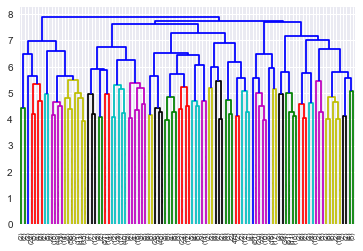

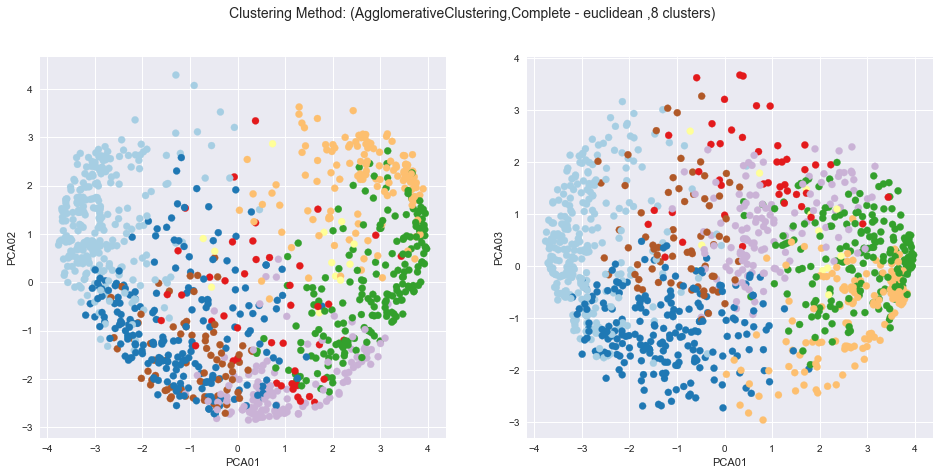

In [23]:
%matplotlib inline
from scipy.cluster import hierarchy


Z = hierarchy.linkage(X_z, method='complete',metric='euclidean')
dn = hierarchy.dendrogram(Z, truncate_mode='lastp', p=100, leaf_rotation=90., leaf_font_size=7., show_contracted=True)
plt.show()



plt.figure()
labels_h_cc = hierarchy.fcluster(Z, t=8 ,criterion = 'maxclust')
hlp.Clusters_plot(X= X_pca, labels = labels_h_cc,info=["AgglomerativeClustering","Complete - euclidean ","%d clusters"%len(set(labels_h_cc))])


SSE["Agg_complete"] = hlp.getSSE(X_z,X_z[labels_h_cc])

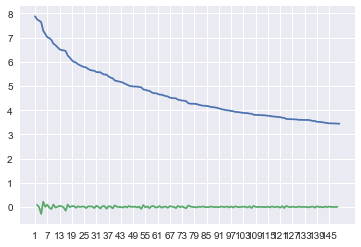

clusters: [  4   5  16  10  17   7   9   2  53  54  36  40  33  39  76  75  57  26
  70  30  31 107  71 123  13 108 124  62  47  59  20  19  21  67  63  66
  34 121  14   8 122 138  35 139  37  44  99  58  11 105  98  80 106  73
  60  74  22  96  27  15  45  46  77  56  97 117 116 135  83  28  38  87
  51  25  55 130  92  95 142   3 143  29 129 145 137  61  91  18  24 115
  72  81  68  86 103  85 127  41 126 120  49  52  89  65 118 114 144  64
 101  12 140  50 113  42  32  78 104 100  69  43  82 125 136  94 141 131
  84 149 112 110  90 148 147   6 128 132 119 146  23 111  48 102 133 109
 134  88  93  79]


In [24]:
last = Z[-150:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.xticks(np.arange(1,len(last),6))
plt.show()
best_ks = np.abs(acceleration_rev).argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

### K-Means: Validate different numbers of clusters

In [ ]:
%matplotlib inline
clusters= np.linspace(10,20,10).astype(int)
inertia = []
silouhaite = []
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster).fit(X_z)
    silouhaite.append(hlp.getSilouhaite(X_z,kmeans.labels_))
    inertia += [np.sqrt(kmeans.inertia_/len(kmeans.labels_))]

plt.figure(figsize=(16,4))
    
plt.subplot(1,2,1)
inertia = np.array(inertia)
plt.title("Total inertia according to clusters")    
plt.plot(np.arange(0,len(clusters)),inertia)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)


acc = np.diff(inertia, 2)  # 2nd derivative of the inertia curve
#plt.plot(np.arange(2,len(clusters)), acc)
best_ks = acc.argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:",clusters[k])



plt.subplot(1,2,2)
silouhaite = np.array(silouhaite)
plt.title("Silouhaite score according to clusters")    
plt.plot(np.arange(0,len(clusters)),silouhaite)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)
best_ks = silouhaite.argsort()[::-1]
print("clusters:",clusters[best_ks])


plt.show()


## Ward Clustering

In [ ]:
n_cluster = 12

from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward').fit(X_z)
label = ward.labels_

SSE['Ward'] = hlp.getSSE(X_z,X_z[label])
print(SSE['Ward'])
hlp.Clusters_plot(X= X_pca, labels = label,info=["AgglomerativeClustering","Ward","%d clusters"%len(set(label))])

## K-means

In [ ]:
%matplotlib inline

kmeans = KMeans(n_clusters=n_cluster).fit(X_z)
label = kmeans.labels_
labels_kmeans = label

SSE["kMeans"] = hlp.getSSE(X_z,X_z[labels_kmeans])

### PCA representation of the clustering

In [ ]:
X = X_pca[:,:3]
hlp.Clusters_plot(X= X_pca, labels = label,info=["K-Means","Euclidean","%d clusters"%len(set(label))])

## Custom Distances

## K-medoid: validate number of clusters using silouhaite

In [25]:
from external import kMedoids
from scipy.spatial.distance import pdist,squareform

n_obs = X_z.shape[1]
# corr_distance = squareform(pdist(X_z, 'correlation'))
euclid_distance = squareform(pdist(X_z, 'euclidean'))

#spearman_distance = squareform(pdist(X_z, lambda u, v: spearmanr_dist(u,v)))

clusters: [ 8 15 10 12 11 13  7  9]
clusters: [ 5  6  7 11  8 15  9 13 12 10]


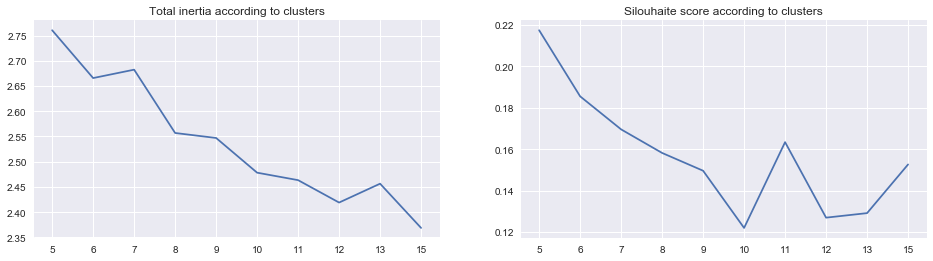

In [29]:
%matplotlib inline
clusters= np.linspace(5,15,10).astype(int)
silouhaite = []
inertia = []
for cluster in clusters:
    labels_kmedoids, medoids = kMedoids.cluster(euclid_distance,k= cluster)
    silouhaite.append(hlp.getSilouhaite(X_z,labels_kmedoids))
    sse = hlp.getSSE(X_z,X_z[labels_kmedoids])
    inertia.append(np.sqrt(sse/len(labels_kmedoids)))
    

plt.figure(figsize=(16,4))
    
plt.subplot(1,2,1)
inertia = np.array(inertia)
plt.title("Total inertia according to clusters")    
plt.plot(np.arange(0,len(clusters)),inertia)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)


acc = np.diff(inertia, 2)  # 2nd derivative of the inertia curve
#plt.plot(np.arange(2,len(clusters)), acc)
best_ks = acc.argsort()#[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:",clusters[k])



plt.subplot(1,2,2)
silouhaite = np.array(silouhaite)
plt.title("Silouhaite score according to clusters")    
plt.plot(np.arange(0,len(clusters)),silouhaite)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)
best_ks = silouhaite.argsort()[::-1]
print("clusters:",clusters[best_ks])

## K-medoids Clustering

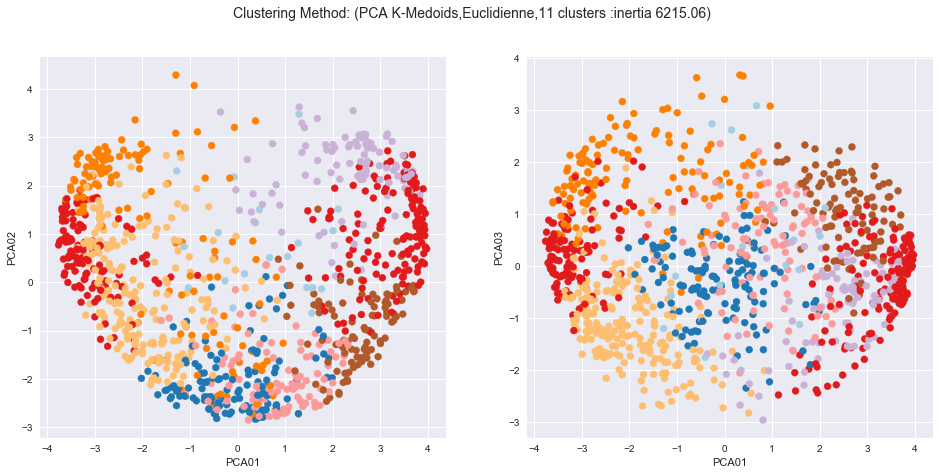

In [39]:
SSE = {}
SILOUHAITE = {}

n_cluster = 11
label, medoids_euc = kMedoids.cluster(euclid_distance,k= n_cluster)
labels_kmedoids = label

# labels_kmedoids_corr,medoids_corr = kMedoids.cluster(corr_distance,k= n_cluster)
# labels_kmedoids_spear,medoids_spear = kMedoids.cluster(corr_distance,k= n_cluster)


SSE["kMedoids"] = hlp.getSSE(X_z,X_z[labels_kmedoids])
# SSE["kMedoids_corr"] = hlp.getSSE(X_z,X_z[labels_kmedoids_corr])
# SSE["kMedoids_spear"] = hlp.getSSE(X_z,X_z[labels_kmedoids_spear])


SILOUHAITE["kMedoids"] = hlp.getSilouhaite(X_z,labels_kmedoids)
# SILOUHAITE["kMedoids_corr"] = hlp.getSilouhaite(X_z,labels_kmedoids_corr)
# SILOUHAITE["kMedoids_spear"] = hlp.getSilouhaite(X_z,labels_kmedoids_spear)


hlp.Clusters_plot(X= X_pca, labels = label
                  ,info=["PCA K-Medoids","Euclidienne","%d clusters :inertia %.2f"%(len(set(label)),SSE["kMedoids"])])

# Save Clustering Results

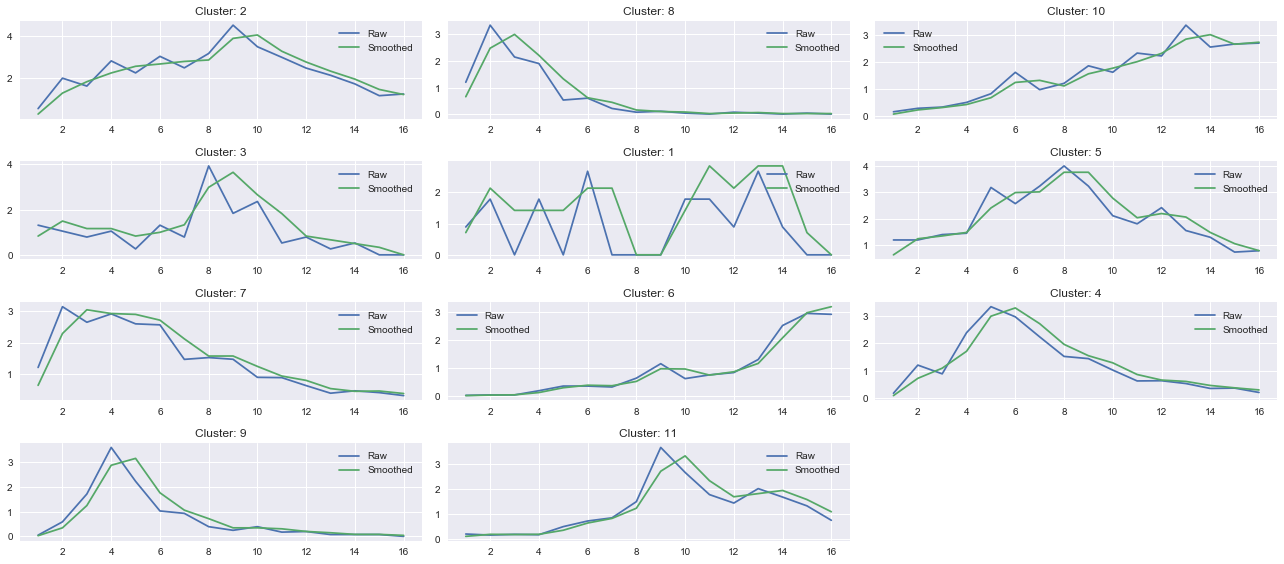

In [46]:
version = 1
filename = "nb_p2_clusters_%s"%(season)

def labels_to_df(df,labels):
    cluster_medoid = {}
    label_cluster = {}
    medoids = list(set(labels))
    
    for i,l in enumerate(medoids):
        medoid = df.index[l]
        cluster_medoid[i+1] = medoid
        label_cluster[l] = i+1

    
    rows=[]
    for i,label in enumerate(labels):
        cluster = label_cluster[label]
        rows.append([cluster,cluster_medoid[cluster]])
    label_df = pd.DataFrame(rows,index = df.index,columns =["Cluster","Centroid"])
    return label_df


eucl_df = labels_to_df(X_train,labels_kmedoids)
save_file(eucl_df,filename,version=version,type_="M",index = True)

# print(eucl_df.shape)
# eucl_df.head()

plot_df = zclean_df.join(eucl_df,how="inner")
va.centroid_grid_plot(raw_df,clean_df,eucl_df)
plt.show()

## Clustering methods Metrics

In [25]:
for k,v in SSE.items():
    print(" \"%s\" : %.2f"%(k,v))

print()
    
for k,v in SILOUHAITE.items():
    print(" \"%s\" : %.2f"%(k,v))

 "kMedoids" : 4936.64

 "kMedoids" : 0.13


# Display Clustering Results

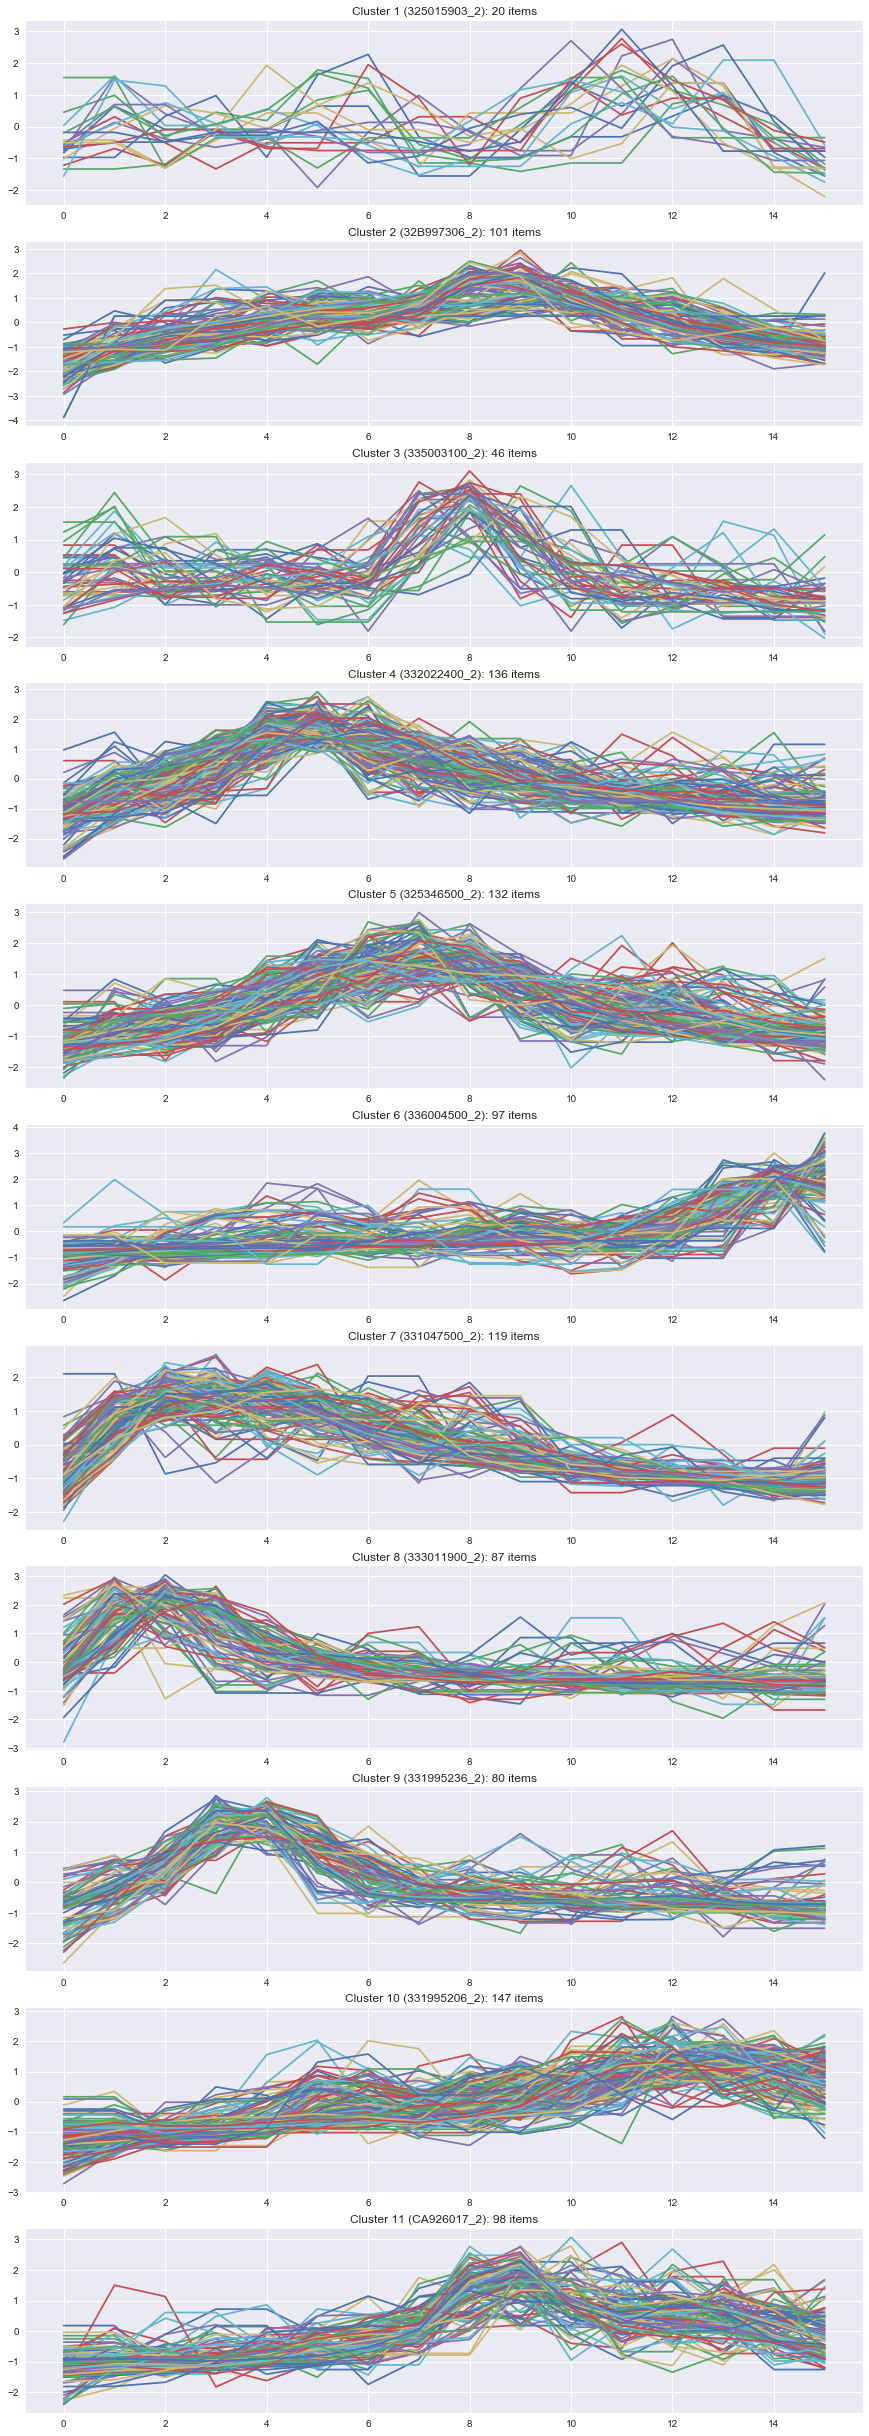

In [47]:
from visualization import visualize as viz
plot_df = zclean_df.join(eucl_df,how="inner")
viz.cluster_plot(plot_df,centroid_only = False)
plt.show()

### t-SNE representation of the clustering

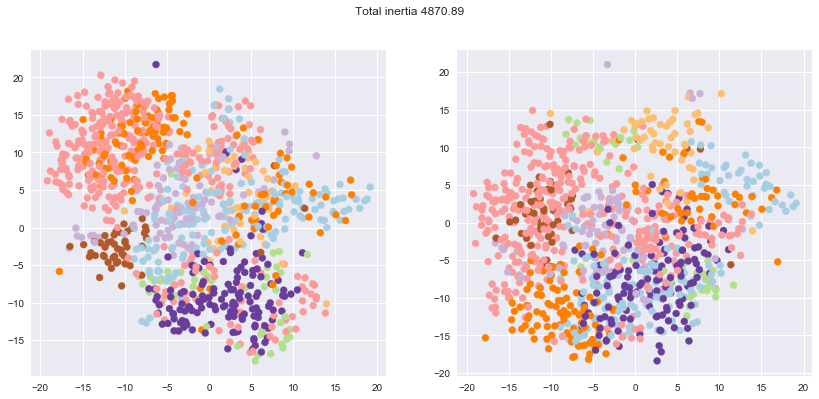

In [18]:
X_tsne = TSNE(n_components = 3).fit_transform(X_z)

plt.figure(figsize=(14,6))
colors = np.array([str(item/255.) for item in labels_kmedoids])
plt.suptitle("Total inertia %.02f"%SSE["kMedoids"])  
plt.subplot(1,2,1)
plt.scatter(X_tsne[:,0],X_tsne[:,1],cmap ="Paired" ,c=colors)
plt.subplot(1,2,2)
plt.scatter(X_tsne[:,0],X_tsne[:,2],cmap ="Paired" ,c=colors)
plt.show(block = True)

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = corr_df,headers = row_headers)

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = spear_df,headers = row_headers)

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = eucl_df,headers = row_headers,centroid_only = True)

########################################################################################################################

########################################################################################################################

# Other Methods

## BIRCH Algorithm

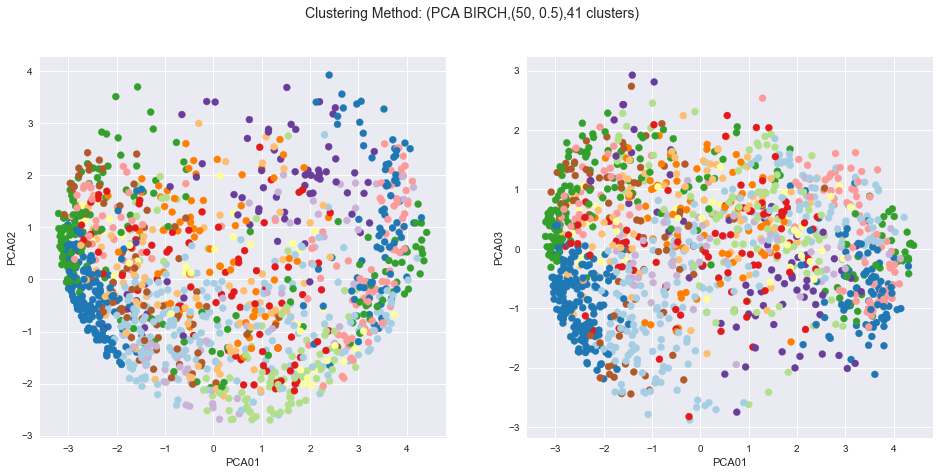

In [90]:
label = Birch(n_clusters= n_cluster, threshold=0.5, compute_labels=True).fit_predict(X_z)
labels_birch = label

SSE["Birch"] = hlp.getSSE(X_z,X_z[labels_birch])

hlp.Clusters_plot(X= X_pca, labels = label,info=["PCA BIRCH","(50, 0.5)","%d clusters"%len(set(label))])

## SOM

In [ ]:
from minisom import MiniSom   


som = MiniSom(14, 14, 104, sigma=0.5, learning_rate=0.01) # initialization of 6x6 SOM

som.train_batch(X_z, 1000) # trains the SOM with 100 iterations

# Plotting the response for each pattern in the iris dataset
plt.bone()
plt.pcolor(som.distance_map().T)  # plotting the distance map as background
plt.colorbar()

qnt = som.quantization(X_z)
x,y = som.winner(X_z[0])


plt.show()


# SOM with SOMpy

In [23]:
import sompy
mapsize = [30,30]

n_cluster = 50

som = sompy.SOMFactory().build(X_z, mapsize, mask=None, mapshape='rectangular', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  

som.train(n_job=1,train_rough_len=10, train_finetune_len=20,verbose=None)  
topographic_error  = som.calculate_topographic_error()
quantization_error = np.mean(som._bmu[1])
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))
som_labels = som.cluster(n_cluster)+1

maxtrainlen %d inf
maxtrainlen %d inf
Topographic error = 0.161133244799; Quantization error = 1.24653106092


In [ ]:
som.component_names = np.arange(X_z.shape[1])
v = sompy.mapview.View2DPacked(50, 50, 'test',text_size=8)  
v.show(som, what='codebook', which_dim='all', cmap='jet', col_sz=6)

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView
vhts  = BmuHitsView(4,4,"Hits Map",text_size=12)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [50]:
bmus = som.project_data(X_z)

pkeys = product_df_full["Product"].values
referents = som_labels[bmus]

som_df =pd.DataFrame(np.vstack((pkeys,referents,pkeys[referents])).T,columns=["Product","Cluster","Centroid"]).set_index('Product')

file_name = "product_7cerf.txt"

non_unique_features=[]

code_features = []

unbalanced = ["Key_lvl2","Key_lvl7","Continuation of","Product Status",'Base Price 1 Coefficient Table',"Sales Season","Product ABC Classification"]

df_produit = pd.read_csv(raw_path+file_name, sep='\t',encoding="utf8")
product_cluster = df_produit.join(som_df,on="Key_lvl1",how='inner')

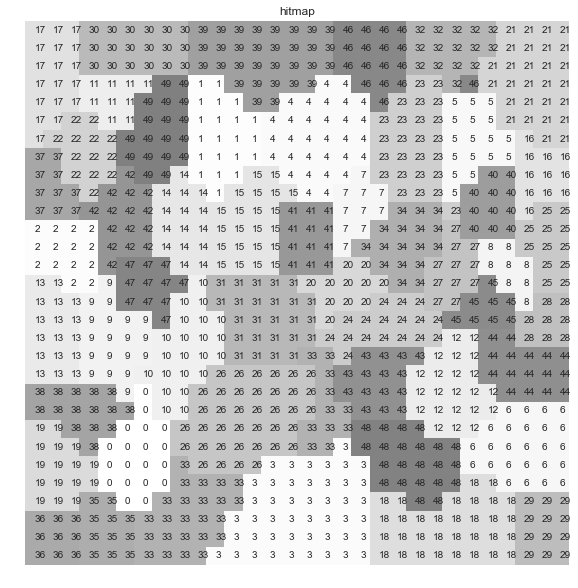

array([[  0,   0,   0],
       [  0,   1,   1],
       [  0,   2,   2],
       ..., 
       [ 29,  27, 897],
       [ 29,  28, 898],
       [ 29,  29, 899]])

In [51]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

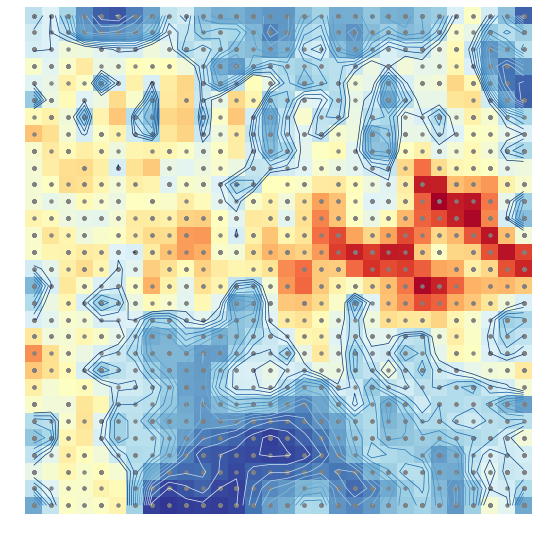

In [52]:
u = sompy.umatrix.UMatrixView(50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(som, distance=1, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(som, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)

# Fuzzy c-means

In [ ]:
import skfuzzy as fuzz

ncenters = n_cluster
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_z.T, ncenters, 2, error=0.005, maxiter=1000, init=None)



labels_fuzzy = np.argmax(u, axis=0)

## Representation methods
### PAA_SAX representation

In [ ]:
from pyts.transformation import PAA,SAX
from pyts.visualization import plot_paa, plot_sax
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
ts = X_z[0].reshape(1,-1)

paa_win = 100
sax_bin = 30


#PAA example
paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
X_paa = paa.transform(ts)
plot_paa(ts[0], window_size=None, output_size=paa_win, overlapping=True, marker='o')

#SAX example
sax = SAX(n_bins=sax_bin, quantiles='gaussian')
X_sax = sax.transform(X_paa)
plot_sax(X_paa[0], n_bins=sax_bin, quantiles='gaussian')
plt.show()

#Extract SAX vector
X_SAX= []
for x in X_z:
    ts = x.reshape(1,-1)
    paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
    X_paa = paa.transform(ts)
    sax = SAX(n_bins=sax_bin, quantiles='gaussian')
    X_sax = sax.transform(X_paa)[0]
    X_SAX.append(list(X_sax))

#Cast back to int
X_SAX = np.array(X_SAX).astype('|S1')
X_SAX = X_SAX.view(np.uint8) - 98
# X_z = X_SAX
# N,M  = X_z.shape


In [125]:
tuple([1,2,3])

(1, 2, 3)